---

# Ансамбли моделей

В этой работе мы рассмотрим применение некоторых классических и хорошо себя показавших алгоритмов-ансамблей. Демонстрировать работу этих алгоритмов будем на данных о потреблении электричества.

# Описание набора данных

**Author**: M. Harries, J. Gama, A. Bifet  
**Source**: [Joao Gama](http://www.inescporto.pt/~jgama/ales/ales_5.html) - 2009  
**Please cite**: None  

**Electricity** is a widely used dataset described by M. Harries and analyzed by J. Gama (see papers below). This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations.

The dataset (originally named ELEC2) contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label. The class label identifies the change of the price (UP or DOWN) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends). 

The data was normalized by A. Bifet.

### Attribute information  
* Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1
* Day: day of the week (1-7)
* Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1
* NSWprice: New South Wales electricity price, normalized between 0 and 1
* NSWdemand: New South Wales electricity demand, normalized between 0 and 1
* VICprice: Victoria electricity price, normalized between 0 and 1
* VICdemand: Victoria electricity demand, normalized between 0 and 1
* transfer: scheduled electricity transfer between both states, normalized between 0 and 1

### Relevant papers  
M. Harries. Splice-2 comparative evaluation: Electricity pricing. Technical report, The University of South Wales, 1999.  
J. Gama, P. Medas, G. Castillo, and P. Rodrigues. Learning with drift detection. In SBIA Brazilian Symposium on Artificial Intelligence, pages 286–295, 2004.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier

# Разведочный анализ данных

Считайте набор данных в датафрейм

In [2]:
data = pd.read_csv('electricity_train.csv')

При помощи метода <code>.describe()</code> изучите набор данных «с высоты птичьего полета».

In [3]:
data.describe()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
count,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000
mean,0.498293,4.006566,0.500560,0.057828,0.425939,0.003455,0.423024,0.500243,0.424536
std,0.339907,1.993551,0.294998,0.039052,0.163390,0.010175,0.120600,0.153098,0.494279
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031945,2.000000,0.255319,0.035187,0.309729,0.002283,0.373382,0.414912,0.000000
50%,0.456263,4.000000,0.510638,0.048787,0.444213,0.003467,0.422915,0.414912,0.000000
75%,0.880492,6.000000,0.765957,0.074457,0.536745,0.003467,0.468669,0.605263,1.000000
max,1.000000,7.000000,1.000000,1.000000,0.980809,1.000000,1.000000,0.959211,1.000000


Убедитесь в отсутствии пропусков. Имеет смысл проверить сбалансированность классов. Введите долю элементов класса $1$.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36249 entries, 0 to 36248
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       36249 non-null  float64
 1   day        36249 non-null  int64  
 2   period     36249 non-null  float64
 3   nswprice   36249 non-null  float64
 4   nswdemand  36249 non-null  float64
 5   vicprice   36249 non-null  float64
 6   vicdemand  36249 non-null  float64
 7   transfer   36249 non-null  float64
 8   class      36249 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 2.5 MB


In [6]:
# task 1
print(len(data[data['class'] == 1])/len(data))

0.4245358492648073


Постройте матрицу корреляций. Определите пару наиболее коррелированных признаков.

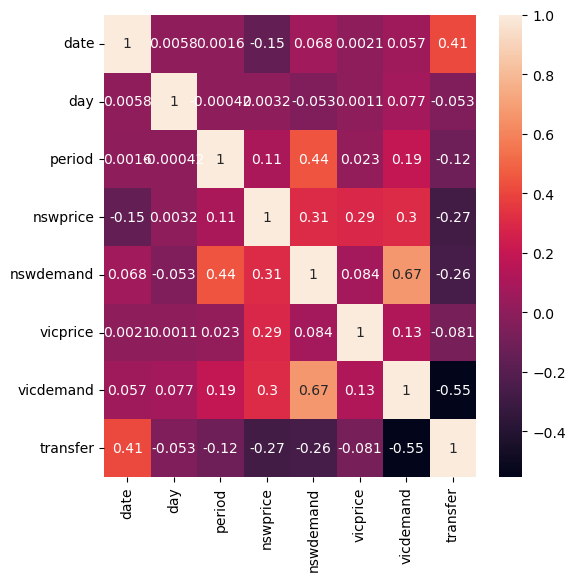

In [7]:
# task 2
correlation_matrix = data.drop(columns=['class']).corr()
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [ ]:
# видно, что это nswdemand и vicdemand

Постройте гистограммы распределений признаков.

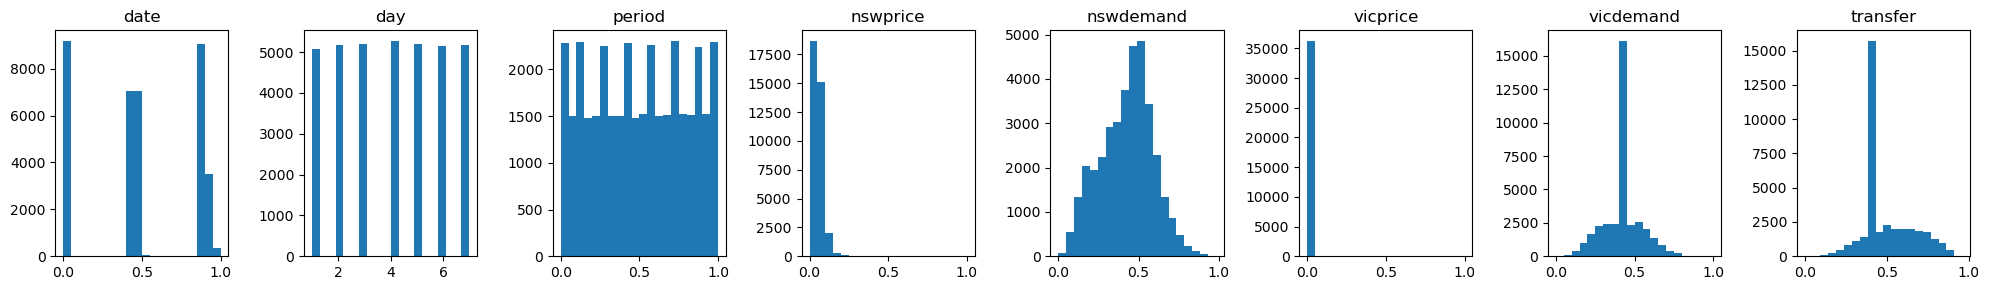

In [8]:
# task 3
plt.figure(figsize=(20, 3))
for i, predictor in enumerate(data.columns[:-1]):
    plt.subplot(1, len(data.columns[:-1]), i + 1)
    plt.hist(data[predictor], bins=20)
    plt.title(predictor)
plt.tight_layout()
plt.show()

Из полученных иллюстраций видно, что в данных, скорее всего, как и ожидалось, есть некоторая периодичность. Более того, похоже, за нас уже поработали над заполнением пропусков или обработкой выбросов

При помощи <code>train_test_split</code> разобейте полученный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем варианте.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['class']), data['class'], test_size=0.2, random_state=41)

# Random Forests Classifier

Обучите модель <code>sklearn.ensemble.RandomForestClassifier</code> на тренировочных данных с параметрами, указанными в вашем индивидуальном задании. 

In [12]:
model = RandomForestClassifier(random_state=21)
model = model.fit(X_train, y_train)
print('RandomForest', round(accuracy_score(y_train, model.predict(X_train)), 3))

RandomForest 1.0


Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [13]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16685
           1       1.00      1.00      1.00     12314

    accuracy                           1.00     28999
   macro avg       1.00      1.00      1.00     28999
weighted avg       1.00      1.00      1.00     28999



Получили переобучение. Что же, еще раз можно ответить, что деревья принятия решений весьма склонны к переобучению.

## Добавление к лесу деревьев GridSearchCV

При помощи <code>sklearn.model_selection.GridSearchCV</code> обучите <code>RandomForestClassifier</code> на тренировочных данных c параметрами, указанными в вашем индивидуальном задании. 

Подбираемые параметры: 

<code>{'n_estimators': [100,300,500], 'max_leaf_nodes': list(range(6,10)), 'min_samples_leaf': [1,2,3]}</code>

In [14]:
params_grid = {'n_estimators': [100,300,500],
               'max_leaf_nodes': list(range(6,10)),
               'min_samples_leaf': [1,2,3]}

In [15]:
clf = GridSearchCV(RandomForestClassifier(
    bootstrap=False,
    class_weight='balanced',
    n_jobs=-1,
    max_features='sqrt',
    random_state=41),
    params_grid,
    verbose=4,
    cv=3)
clf.fit(X_train, y_train)  

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.771 total time=   2.3s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.771 total time=   0.4s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.768 total time=   0.4s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.771 total time=   1.4s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.772 total time=   1.4s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.767 total time=   1.3s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.771 total time=   4.2s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.773 total time=   4.2s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.768 total time=   4.2s
[CV 1/3] END max_leaf_nodes=6

[CV 1/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=100;, score=0.784 total time=   1.0s
[CV 2/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=100;, score=0.786 total time=   0.9s
[CV 3/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=100;, score=0.782 total time=   0.9s
[CV 1/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=300;, score=0.785 total time=   2.9s
[CV 2/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=300;, score=0.788 total time=   2.6s
[CV 3/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=300;, score=0.781 total time=   2.7s
[CV 1/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=500;, score=0.785 total time=   4.6s
[CV 2/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=500;, score=0.788 total time=   4.2s
[CV 3/3] END max_leaf_nodes=9, min_samples_leaf=1, n_estimators=500;, score=0.782 total time=   5.1s
[CV 1/3] END max_leaf_nodes=9, min_samples_leaf=2, n_estimators=100;, score=0.784 total tim

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False,
                                              class_weight='balanced',
                                              n_jobs=-1, random_state=41),
             param_grid={'max_leaf_nodes': [6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 300, 500]},
             verbose=4)

Выберите лучшую модель. Рекомендуем использовать поле <code>best_estimator_</code> объекта класса <code>grid_search</code>. В поле <code>best_params_</code> этого же объекта можно найти параметры лучшей модели. 

In [16]:
clf.best_params_

{'max_leaf_nodes': 9, 'min_samples_leaf': 1, 'n_estimators': 500}

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [19]:
print('Grid_train', round(accuracy_score(y_train, clf.best_estimator_.predict(X_train)), 3))
print(classification_report(y_train, clf.best_estimator_.predict(X_train), digits=3))

Grid_train 0.789
              precision    recall  f1-score   support

           0      0.782     0.878     0.827     16685
           1      0.802     0.668     0.729     12314

    accuracy                          0.789     28999
   macro avg      0.792     0.773     0.778     28999
weighted avg      0.790     0.789     0.786     28999



Постройте <code>classification_report</code> полученной модели на **тестовых данных**. Введите значение точности модели на **тестовых данных**.

In [20]:
print('Grid_test', round(accuracy_score(y_test, clf.best_estimator_.predict(X_test)), 3))
print(classification_report(y_test, clf.best_estimator_.predict(X_test), digits=3))

Grid_test 0.79
              precision    recall  f1-score   support

           0      0.783     0.880     0.829      4175
           1      0.804     0.669     0.730      3075

    accuracy                          0.790      7250
   macro avg      0.793     0.774     0.779      7250
weighted avg      0.792     0.790     0.787      7250



От переобучения избавились, но точность кажется низкой.

Один из плюсов случайного леса — можно посмотреть на важность признаков при классификации (обратная задача). Значения важности можно найти в поле <code>feature_importances_</code> модели. Определите название самого важного признака модели.

In [24]:
data.columns[np.argmax(clf.best_estimator_.feature_importances_)]

'nswprice'

Попробуем улучшить результаты, используя другие виды ансамблей.

# Voting Classifier

Обучает все модели, поданные на вход, и предсказывает финальный результат либо по большему числу одинаковых ответов, которые дали модели (hard), либо вычисляет вероятность отнесения объектов к классам по всем моделям и берет argmax.

Используйте объект <code>sklearn.ensemble.VotingClassifier</code> с параметром <code>voting='hard'</code>. В качестве базовых алгоритмов используйте классификаторы с соответствующими параметрами, указанными в вашем индивидуальном задании. Обучите модель на тренировочных данных

In [26]:
estimators = [('log', LogisticRegression(solver='liblinear', random_state=41)), 
              ('svc', SVC(random_state=41)), 
              ('sgd', SGDClassifier(random_state=41))
             ]
vote_model = VotingClassifier(estimators = estimators, voting='hard')
vote_model.fit(X_train, y_train)

VotingClassifier(estimators=[('log',
                              LogisticRegression(random_state=41,
                                                 solver='liblinear')),
                             ('svc', SVC(random_state=41)),
                             ('sgd', SGDClassifier(random_state=41))])

Вычислите точность модели на **тренировочных данных**

In [27]:
print('vote_model_train', round(accuracy_score(y_train, vote_model.predict(X_train)), 3))
print(classification_report(y_train, vote_model.predict(X_train), digits=3))

vote_model_train 0.743
              precision    recall  f1-score   support

           0      0.714     0.925     0.806     16685
           1      0.830     0.497     0.622     12314

    accuracy                          0.743     28999
   macro avg      0.772     0.711     0.714     28999
weighted avg      0.763     0.743     0.728     28999



Вычислите точность модели на **тестовых данных**

In [28]:
print('vote_model_test', round(accuracy_score(y_test, vote_model.predict(X_test)), 3))
print(classification_report(y_test, vote_model.predict(X_test), digits=3))

vote_model_test 0.743
              precision    recall  f1-score   support

           0      0.714     0.923     0.805      4175
           1      0.827     0.498     0.621      3075

    accuracy                          0.743      7250
   macro avg      0.770     0.710     0.713      7250
weighted avg      0.762     0.743     0.727      7250



# Bagging Classifier

Создает несколько объектов одного класса (несколько моделей) и обучает их на непересекающихся подмножествах тренировочных данных, а дальше усредняет ответы.

На основе <code>sklearn.ensemble.BaggingClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [30]:
beg_model = BaggingClassifier(DecisionTreeClassifier(class_weight='balanced'), 
                              max_samples=0.5, max_features=0.5, bootstrap=False, random_state=41)

beg_model.fit(X_train, y_train)

BaggingClassifier(bootstrap=False,
                  estimator=DecisionTreeClassifier(class_weight='balanced'),
                  max_features=0.5, max_samples=0.5, random_state=41)

Вычислите точность модели на **тренировочных данных**

In [31]:
print('beg_model_train', round(accuracy_score(y_train, beg_model.predict(X_train)), 3))
print(classification_report(y_train, beg_model.predict(X_train), digits=3))

beg_model_train 0.976
              precision    recall  f1-score   support

           0      0.969     0.989     0.979     16685
           1      0.984     0.958     0.971     12314

    accuracy                          0.976     28999
   macro avg      0.977     0.973     0.975     28999
weighted avg      0.976     0.976     0.976     28999



Вычислите точность модели на **тестовых данных**

In [32]:
print('beg_model_test', round(accuracy_score(y_test, beg_model.predict(X_test)), 3))
print(classification_report(y_test, beg_model.predict(X_test), digits=3))

beg_model_test 0.85
              precision    recall  f1-score   support

           0      0.841     0.912     0.875      4175
           1      0.865     0.767     0.813      3075

    accuracy                          0.850      7250
   macro avg      0.853     0.839     0.844      7250
weighted avg      0.851     0.850     0.849      7250



# Gradient Boosting Classifier

Градиентный бустинг работает примерно так: создается несколько объектов класса (несколько моделей), они выстраиваются в цепочку так, чтобы каждый следующий пытался исправить ошибки предыдущего. Склонен к переобучению.

Обучите модель на основе <code>sklearn.ensemble.GradientBoostingClassifier</code> с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [34]:
grad_model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.8, random_state=41, max_depth=2)
grad_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.8, max_depth=2, n_estimators=500,
                           random_state=41)

Вычислите точность модели на **тренировочных данных**

In [36]:
print(classification_report(y_train, grad_model.predict(X_train), digits=3))

              precision    recall  f1-score   support

           0      0.934     0.947     0.941     16685
           1      0.927     0.910     0.918     12314

    accuracy                          0.931     28999
   macro avg      0.931     0.929     0.930     28999
weighted avg      0.931     0.931     0.931     28999



Вычислите точность модели на **тестовых данных**

In [37]:
print(classification_report(y_test, grad_model.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.910     0.914     0.912      4175
           1      0.882     0.877     0.880      3075

    accuracy                          0.898      7250
   macro avg      0.896     0.895     0.896      7250
weighted avg      0.898     0.898     0.898      7250



# AdaBoost Classifier

Работает похожим на градиентный бустинг образом, только последующие модели не пытаются исправить ошибку предыдущих: сначала первый объект обучается на всем датасете, а следующий на основе опыта предыдущего обновляет свои веса так, чтобы исправлять ошибочные предсказания.

На основе <code>sklearn.ensemble.AdaBoostClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [38]:
ada_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
                               n_estimators=300, learning_rate=0.5, random_state=41)

ada_model.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=3),
                   learning_rate=0.5, n_estimators=300, random_state=41)

Вычислите точность модели на **тренировочных данных**

In [39]:
print(classification_report(y_train, ada_model.predict(X_train), digits=3))

              precision    recall  f1-score   support

           0      0.960     0.933     0.947     16685
           1      0.913     0.947     0.930     12314

    accuracy                          0.939     28999
   macro avg      0.937     0.940     0.938     28999
weighted avg      0.940     0.939     0.940     28999



Вычислите точность модели на **тестовых данных**

In [40]:
print(classification_report(y_test, ada_model.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.927     0.897     0.912      4175
           1      0.866     0.904     0.884      3075

    accuracy                          0.900      7250
   macro avg      0.896     0.900     0.898      7250
weighted avg      0.901     0.900     0.900      7250



# Stacking Classifier

Обучает несколько объектов класса (несколько моделей) на всем наборе данных, а после — обучает отдельный классификатор на метданных — ответах, полученных обученными ранее моделями.

Используйте объект <code>sklearn.ensemble.StackingClassifier</code>. Базовые алгоритмы и решающий, а также соответствующие параметры указанны в вашем индивидуальном задании. Обучите модель на тренировочных данных.

In [42]:
estimators = [('for', RandomForestClassifier(random_state=41)), 
              ('svc', SVC(random_state=41))
             ]
stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=41))
stack_model.fit(X_train, y_train)

StackingClassifier(estimators=[('for', RandomForestClassifier(random_state=41)),
                               ('svc', SVC(random_state=41))],
                   final_estimator=LogisticRegression(random_state=41))

Вычислите точность модели на **тренировочных данных**

In [43]:
print(classification_report(y_train, stack_model.predict(X_train), digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     16685
           1      1.000     0.999     1.000     12314

    accuracy                          1.000     28999
   macro avg      1.000     1.000     1.000     28999
weighted avg      1.000     1.000     1.000     28999



Вычислите точность модели на **тестовых данных**

In [44]:
print(classification_report(y_test, stack_model.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.911     0.921     0.916      4175
           1      0.892     0.878     0.885      3075

    accuracy                          0.903      7250
   macro avg      0.902     0.900     0.901      7250
weighted avg      0.903     0.903     0.903      7250



### Задание 2

In [45]:
X_test = pd.read_csv('electricity_reserved.csv')
X_train, y_train = data.drop(columns=['class']), data['class']

In [49]:
best_model = CatBoostClassifier(iterations=1000, learning_rate=1, depth=9)
best_model.fit(X_train, y_train)
print(round(accuracy_score(y_train, best_model.predict(X_train)), 3))

0:	learn: 0.4700234	total: 270ms	remaining: 4m 29s
1:	learn: 0.4356175	total: 428ms	remaining: 3m 33s
2:	learn: 0.4114569	total: 584ms	remaining: 3m 14s
3:	learn: 0.3939176	total: 734ms	remaining: 3m 2s
4:	learn: 0.3861454	total: 888ms	remaining: 2m 56s
5:	learn: 0.3794663	total: 1.02s	remaining: 2m 48s
6:	learn: 0.3674636	total: 1.16s	remaining: 2m 44s
7:	learn: 0.3560565	total: 1.3s	remaining: 2m 41s
8:	learn: 0.3476347	total: 1.45s	remaining: 2m 39s
9:	learn: 0.3376793	total: 1.59s	remaining: 2m 37s
10:	learn: 0.3286174	total: 1.65s	remaining: 2m 28s
11:	learn: 0.3225845	total: 1.73s	remaining: 2m 22s
12:	learn: 0.3137317	total: 1.82s	remaining: 2m 18s
13:	learn: 0.3063317	total: 1.92s	remaining: 2m 14s
14:	learn: 0.2993531	total: 2.02s	remaining: 2m 12s
15:	learn: 0.2901069	total: 2.13s	remaining: 2m 10s
16:	learn: 0.2860805	total: 2.22s	remaining: 2m 8s
17:	learn: 0.2795619	total: 2.35s	remaining: 2m 8s
18:	learn: 0.2730956	total: 2.5s	remaining: 2m 9s
19:	learn: 0.2672499	total: 

158:	learn: 0.0452142	total: 17.7s	remaining: 1m 33s
159:	learn: 0.0448140	total: 17.8s	remaining: 1m 33s
160:	learn: 0.0444482	total: 17.9s	remaining: 1m 33s
161:	learn: 0.0441973	total: 18s	remaining: 1m 33s
162:	learn: 0.0439008	total: 18.1s	remaining: 1m 33s
163:	learn: 0.0434158	total: 18.3s	remaining: 1m 33s
164:	learn: 0.0431618	total: 18.4s	remaining: 1m 32s
165:	learn: 0.0428700	total: 18.5s	remaining: 1m 32s
166:	learn: 0.0425991	total: 18.6s	remaining: 1m 32s
167:	learn: 0.0423061	total: 18.7s	remaining: 1m 32s
168:	learn: 0.0419019	total: 18.8s	remaining: 1m 32s
169:	learn: 0.0416161	total: 18.9s	remaining: 1m 32s
170:	learn: 0.0413257	total: 19.1s	remaining: 1m 32s
171:	learn: 0.0410325	total: 19.2s	remaining: 1m 32s
172:	learn: 0.0405677	total: 19.3s	remaining: 1m 32s
173:	learn: 0.0401248	total: 19.4s	remaining: 1m 32s
174:	learn: 0.0398401	total: 19.5s	remaining: 1m 32s
175:	learn: 0.0395903	total: 19.7s	remaining: 1m 32s
176:	learn: 0.0392407	total: 19.8s	remaining: 1m

314:	learn: 0.0144316	total: 34.2s	remaining: 1m 14s
315:	learn: 0.0143453	total: 34.3s	remaining: 1m 14s
316:	learn: 0.0142755	total: 34.5s	remaining: 1m 14s
317:	learn: 0.0141154	total: 34.6s	remaining: 1m 14s
318:	learn: 0.0140332	total: 34.8s	remaining: 1m 14s
319:	learn: 0.0139523	total: 34.9s	remaining: 1m 14s
320:	learn: 0.0138597	total: 35s	remaining: 1m 14s
321:	learn: 0.0137269	total: 35.1s	remaining: 1m 13s
322:	learn: 0.0135964	total: 35.2s	remaining: 1m 13s
323:	learn: 0.0135456	total: 35.3s	remaining: 1m 13s
324:	learn: 0.0134463	total: 35.4s	remaining: 1m 13s
325:	learn: 0.0133434	total: 35.5s	remaining: 1m 13s
326:	learn: 0.0133431	total: 35.5s	remaining: 1m 13s
327:	learn: 0.0133404	total: 35.6s	remaining: 1m 12s
328:	learn: 0.0132877	total: 35.6s	remaining: 1m 12s
329:	learn: 0.0132135	total: 35.7s	remaining: 1m 12s
330:	learn: 0.0131264	total: 35.9s	remaining: 1m 12s
331:	learn: 0.0130601	total: 36s	remaining: 1m 12s
332:	learn: 0.0129916	total: 36.1s	remaining: 1m 1

474:	learn: 0.0087781	total: 49.7s	remaining: 55s
475:	learn: 0.0087779	total: 49.8s	remaining: 54.8s
476:	learn: 0.0087779	total: 49.9s	remaining: 54.7s
477:	learn: 0.0087776	total: 50s	remaining: 54.6s
478:	learn: 0.0087420	total: 50.1s	remaining: 54.5s
479:	learn: 0.0087318	total: 50.2s	remaining: 54.4s
480:	learn: 0.0086989	total: 50.3s	remaining: 54.3s
481:	learn: 0.0086975	total: 50.4s	remaining: 54.1s
482:	learn: 0.0086975	total: 50.4s	remaining: 53.9s
483:	learn: 0.0086617	total: 50.5s	remaining: 53.8s
484:	learn: 0.0086616	total: 50.6s	remaining: 53.7s
485:	learn: 0.0086517	total: 50.6s	remaining: 53.6s
486:	learn: 0.0086191	total: 50.7s	remaining: 53.4s
487:	learn: 0.0086187	total: 50.8s	remaining: 53.3s
488:	learn: 0.0086187	total: 50.9s	remaining: 53.2s
489:	learn: 0.0086183	total: 50.9s	remaining: 53s
490:	learn: 0.0086182	total: 51s	remaining: 52.9s
491:	learn: 0.0086180	total: 51.1s	remaining: 52.8s
492:	learn: 0.0086030	total: 51.2s	remaining: 52.7s
493:	learn: 0.008565

634:	learn: 0.0079344	total: 1m 3s	remaining: 36.4s
635:	learn: 0.0079344	total: 1m 3s	remaining: 36.3s
636:	learn: 0.0079341	total: 1m 3s	remaining: 36.2s
637:	learn: 0.0079133	total: 1m 3s	remaining: 36.1s
638:	learn: 0.0079133	total: 1m 3s	remaining: 36s
639:	learn: 0.0079132	total: 1m 3s	remaining: 35.9s
640:	learn: 0.0079131	total: 1m 3s	remaining: 35.8s
641:	learn: 0.0079130	total: 1m 3s	remaining: 35.7s
642:	learn: 0.0079129	total: 1m 4s	remaining: 35.5s
643:	learn: 0.0079128	total: 1m 4s	remaining: 35.4s
644:	learn: 0.0079128	total: 1m 4s	remaining: 35.3s
645:	learn: 0.0079127	total: 1m 4s	remaining: 35.2s
646:	learn: 0.0079127	total: 1m 4s	remaining: 35.1s
647:	learn: 0.0079126	total: 1m 4s	remaining: 35s
648:	learn: 0.0079126	total: 1m 4s	remaining: 34.9s
649:	learn: 0.0079125	total: 1m 4s	remaining: 34.8s
650:	learn: 0.0079124	total: 1m 4s	remaining: 34.7s
651:	learn: 0.0079124	total: 1m 4s	remaining: 34.6s
652:	learn: 0.0079123	total: 1m 4s	remaining: 34.5s
653:	learn: 0.00

791:	learn: 0.0076405	total: 1m 16s	remaining: 20.1s
792:	learn: 0.0076403	total: 1m 16s	remaining: 20s
793:	learn: 0.0076402	total: 1m 16s	remaining: 19.9s
794:	learn: 0.0076401	total: 1m 16s	remaining: 19.8s
795:	learn: 0.0076400	total: 1m 16s	remaining: 19.7s
796:	learn: 0.0076400	total: 1m 16s	remaining: 19.6s
797:	learn: 0.0076399	total: 1m 16s	remaining: 19.5s
798:	learn: 0.0076398	total: 1m 17s	remaining: 19.4s
799:	learn: 0.0076397	total: 1m 17s	remaining: 19.3s
800:	learn: 0.0076397	total: 1m 17s	remaining: 19.2s
801:	learn: 0.0076395	total: 1m 17s	remaining: 19.1s
802:	learn: 0.0076394	total: 1m 17s	remaining: 19s
803:	learn: 0.0076392	total: 1m 17s	remaining: 18.9s
804:	learn: 0.0076389	total: 1m 17s	remaining: 18.8s
805:	learn: 0.0076388	total: 1m 17s	remaining: 18.7s
806:	learn: 0.0076387	total: 1m 17s	remaining: 18.6s
807:	learn: 0.0076385	total: 1m 17s	remaining: 18.5s
808:	learn: 0.0076384	total: 1m 18s	remaining: 18.4s
809:	learn: 0.0076384	total: 1m 18s	remaining: 18.

947:	learn: 0.0074360	total: 1m 30s	remaining: 4.95s
948:	learn: 0.0074359	total: 1m 30s	remaining: 4.85s
949:	learn: 0.0074359	total: 1m 30s	remaining: 4.75s
950:	learn: 0.0074357	total: 1m 30s	remaining: 4.66s
951:	learn: 0.0074351	total: 1m 30s	remaining: 4.56s
952:	learn: 0.0074350	total: 1m 30s	remaining: 4.46s
953:	learn: 0.0074349	total: 1m 30s	remaining: 4.37s
954:	learn: 0.0074348	total: 1m 30s	remaining: 4.27s
955:	learn: 0.0074347	total: 1m 30s	remaining: 4.17s
956:	learn: 0.0074346	total: 1m 30s	remaining: 4.08s
957:	learn: 0.0074345	total: 1m 30s	remaining: 3.98s
958:	learn: 0.0074344	total: 1m 30s	remaining: 3.88s
959:	learn: 0.0074342	total: 1m 30s	remaining: 3.79s
960:	learn: 0.0074342	total: 1m 31s	remaining: 3.69s
961:	learn: 0.0074341	total: 1m 31s	remaining: 3.6s
962:	learn: 0.0074339	total: 1m 31s	remaining: 3.5s
963:	learn: 0.0074338	total: 1m 31s	remaining: 3.41s
964:	learn: 0.0074337	total: 1m 31s	remaining: 3.31s
965:	learn: 0.0074334	total: 1m 31s	remaining: 3

In [54]:
result = best_model.predict(X_test)
# res_str = '['
# for elem in result:
#     res_str+= str(elem) + ','
# res_str = res_str[:-1]   
# res_str += ']'
# print(res_str)
# print('')